In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
from sklearn.metrics import mean_squared_error
from keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def scale_minmax(col):
    return (col - col.min()) / (col.max() - col.min())


def mse(y_ture, y_pred):
    return mean_squared_error(y_ture, y_pred)

In [3]:
# 加载训练数据
train_dataset = pd.read_csv('./data.tsv', sep='\t', skipinitialspace=True)
# 加载测试数据     ！！！ 测试数据集为真实值，不能进行调整，否则将会导致实际模型测试结果和真实预测结果存在偏差，使得最终加工的作品和预期不一致
test_dataset = pd.read_csv('./test_adjustments.tsv', sep='\t', skipinitialspace=True)

In [4]:
np.set_printoptions(precision=3, suppress=True)
dataset = train_dataset.copy()

average = np.average(dataset.values[:, :18], axis=0)
variance = np.var(dataset.values[:, :18], axis=0)


In [5]:
train_features = dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features[['补偿' + str(i) for i in range(8)]].copy()
test_labels = test_features[['补偿' + str(i) for i in range(8)]].copy()

train_features = train_features.drop(['补偿' + str(i) for i in range(8)], axis=1)
test_features = test_features.drop(['补偿' + str(i) for i in range(8)], axis=1)


In [6]:
# 创建模型
model = tf.keras.Sequential([
    layers.Dense(600, input_dim=train_features.shape[1], activation="relu"),
    layers.BatchNormalization(),
    layers.Dense(600, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dense(train_labels.shape[1])
])

# 调整学习率
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=5)

model.compile(loss="mse", optimizer="adam")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 600)               11400     
                                                                 
 batch_normalization (BatchN  (None, 600)              2400      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 600)               360600    
                                                                 
 batch_normalization_1 (Batc  (None, 600)              2400      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 8)                 4808      
                                                                 
Total params: 381,608
Trainable params: 379,208
Non-trai

2023-08-28 12:15:48.633814: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-28 12:15:48.633848: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-28 12:15:48.633874: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (58c881efe57c): /proc/driver/nvidia/version does not exist
2023-08-28 12:15:48.634037: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7586 - val_loss: 5.2519 - lr: 0.0010
Epoch 2/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2816 - val_loss: 3.8848 - lr: 0.0010
Epoch 3/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2480 - val_loss: 10.8065 - lr: 0.0010
Epoch 4/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2521 - val_loss: 4.0316 - lr: 0.0010
Epoch 5/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2554 - val_loss: 1.4032 - lr: 0.0010
Epoch 6/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2572 - val_loss: 1.2245 - lr: 0.0010
Epoch 7/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2313 - val_loss: 6.0709 - lr: 0.0010
Epoch 8/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2282 - val_loss: 1.2033 - lr: 0.0010
Epoch 9/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2

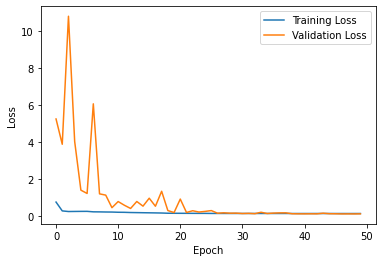

[[ 0.307  0.024  0.268 ...  0.742  0.341  2.054]
 [ 0.924 -0.008  0.074 ...  0.598  0.936  0.781]
 [ 1.    -0.015  1.014 ...  0.788  0.612  0.903]
 ...
 [ 0.722 -0.006  0.453 ...  0.672  0.609  0.379]
 [ 0.502 -0.003  0.428 ...  0.44  -0.239  0.663]
 [ 0.566  0.015 -0.303 ...  0.665  0.027 -0.231]] (2998, 8)
y1 MSE:0.1189
y1 MSE:2998.0000 ------ 2998


In [7]:
# 添加验证集
history = model.fit(train_features, train_labels, epochs=50, batch_size=32, validation_split=0.2, callbacks=[lr_scheduler])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_preds = model.predict(test_features)
print(test_preds, test_preds.shape)
print("y1 MSE:%.4f" % mean_squared_error(test_labels, test_preds))
print("y1 MSE:%.4f" % len(test_labels), '------', len(test_preds))


In [8]:
train_features = dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features[['补偿'+str(i) for i in range(8)]].copy()
test_labels = test_features[['补偿'+str(i) for i in range(8)]].copy()

train_features = train_features.drop(['补偿'+str(i) for i in range(8)], axis=1)
test_features = test_features.drop(['补偿'+str(i) for i in range(8)], axis=1)

print(train_features.shape, train_labels.shape)
print(test_features.shape, test_labels.shape)

(50000, 18) (50000, 8)
(2998, 18) (2998, 8)


In [9]:
test_preds = model.predict(test_features)
print("y1 MSE:%.4f" % mean_squared_error(test_labels, test_preds))
print("y1 MSE:%.4f" % len(test_labels), '------',len(test_preds))

y1 MSE:0.1189
y1 MSE:2998.0000 ------ 2998


In [10]:
import pytz
from datetime import datetime

model_version =  datetime.now(pytz.timezone('Asia/Shanghai')).strftime('%Y%m%d%H%M%S')
tf.keras.models.save_model(
    model,
    f'/models/slot0/{model_version}/', # v1/models/slot0/为tensorflow-serving的模型根目录
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

2023-08-28 12:19:14.310415: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /models/slot0/20230828201914/assets


In [12]:
import json
import requests
from pprint import pprint

req_data = json.dumps({
            'inputs': test_features.values[:1].tolist()
        })
print(req_data)

response = requests.post(f'http://fireeye-test-model-container:8501/v1/models/slot0/versions/{model_version}:predict', # 根据部署地址填写
                         data=req_data,
                         headers={"content-type": "application/json"})
if response.status_code != 200:
    raise RuntimeError('Request tf-serving failed: ' + response.text)
resp_data = json.loads(response.text)
if 'outputs' not in resp_data \
                    or type(resp_data['outputs']) is not list:
    raise ValueError('Malformed tf-serving response')

print(resp_data)
print("{'outputs':",test_labels.values[:1].tolist())

print("y1 MSE:%.4f" % mean_squared_error(test_labels.values[:1].tolist(), resp_data['outputs']))

{"inputs": [[1.4158, 2.9711, 10.7935, 7.5279, 2.3352, 8.1042, 2.3096, 3.3367, 11.8639, 12.7142, 1.8581, 0.3898, 19.8309, 19.771, 0.0001, 1.7768, 171.764, 1434.24]]}
{'outputs': [[0.306851804, 0.0244900789, 0.268039346, -0.107504457, -0.816312671, 0.74183, 0.341438711, 2.05432606]]}
{'outputs': [[0.331511, -0.932553, 0.285048, -0.1435, -0.833982, 0.767568, 0.463969, 1.9048]]
y1 MSE:0.1196
